In [561]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import os
from sklearn.metrics import mean_squared_error

In [562]:
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2','AUX_1', 'ACC_X', 'ACC_Y', 'ACC_Z']
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# TODO ADD AUX WHEN CONNECTED
eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink', 'left_openness', 'right_openness']

columns =  eye_data_names + channels



In [563]:
def get_time_stamps(stamps: list):
    start = []
    end = []
    more_than_one = False

    for i in range(len(stamps)):
        if i == (len(stamps)-1):
            if(stamps[i-1] == (stamps[i] - 1)):
                end.append(stamps[i])
            break

        if(stamps[i] == (stamps[i+1] - 1)):
            if not more_than_one:
                start.append(stamps[i])
            more_than_one = True
            continue
        else:
            if more_than_one:
                end.append(stamps[i])
                more_than_one = False

    return start, end

In [564]:
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    axis.plot(df_ts['time'][start-rang:end+rang], (df_norm + plus) *(-1 if flip else 1) *scale, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Amplitude ")
    axis.set_title(column)
    plt.legend()
    plt.show()

def plot_eeg_blink_single(df,df_ts, start, end,column,rang = 50):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")

    axis.plot(df_ts['time'][start-rang:end+rang], df[column], label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], df['left_openness'], color='orange', label = "Eye openness left - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], df['right_openness'], color='violet', label = "Eye openness right - SRanipal")
    axis.set_title(column)
    plt.legend()
    plt.show()

In [565]:

"""
Method to apply a zero-phase Butterworth filter to the data
Uses bandpass [0.75-5], and order 4
"""
def zero_phase_butter(data):
    # Filter parameters
    fs = 250
    lowcut =0.75
    highcut = 5.0
    order = 3

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b_bandpass, a_bandpass = signal.butter(order, [low, high], btype="band")

    # Zero-phase filtering using filtfilt
    return signal.filtfilt(b_bandpass, a_bandpass, data)

def init_data(data, shift = 0):
    for s in data:
        stream = s
        y = stream['time_series']
        df_stream = pd.DataFrame(y)
        df_stream_ts = pd.DataFrame(stream['time_stamps'])
        df_stream_ts.columns = ['time']
        df_stream.columns = columns
        #df_stream['AUX_1'] = zero_phase_butter(df_stream['AUX_1'])
        df_stream['AUX_1'] = df_stream['AUX_1']+ 1000000
        if shift != 0:
            df_stream['AUX_1'] = df_stream['AUX_1'].shift(shift)
        return stream, df_stream, df_stream_ts

def get_blinks_in_df(df):
    left_blinks = df.index[(df['left_blink'] >= 1) & (df['right_blink'] != 1)].tolist()
    right_blinks = df.index[(df['right_blink'] >= 1) & (df['left_blink'] != 1)].tolist()
    both_blink = df.index[df['both_blink'] == 1].tolist()
    return left_blinks,right_blinks, both_blink



In [566]:

chosen_channel = 'AUX_1'



In [567]:
from scipy.signal import butter, lfilter
# Sample rate and desired cutoff frequencies (in Hz).






def plot_eeg_blink_single_norm_butter(df,df_ts, start, end,column,rang = 50, scale=1, flip = False, order = 4):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]

    y = (df_norm + plus) *(-1 if flip else 1) *scale
    peaks, _ = signal.find_peaks(y[rang:])
    peaks = [peak + rang for peak in peaks]

    axis.plot(df_ts['time'][start-rang:end+rang], y, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Normalized Amplitude")
    for i in peaks:
        plt.plot(df_ts['time'][i+ start - rang], y[i], marker="o", markersize=5, markeredgecolor="turquoise", markerfacecolor="black", label="Local maximum " + str(y[i].round(2)) + ", " + str(i+ start - rang))
    axis.set_title(column)
    plt.legend()
    plt.show()

def get_peaks(df, start, end, column, rang=50, scale=1, order=4, flip=False):
    df = df[start - rang:end + rang]
    df_norm = (df[column].abs() / df[column].abs().max())
    df_norm = df_norm.reset_index(drop=True)
    peaks, _ = signal.find_peaks(df_norm)

    print(peaks)
    print(df_norm)
    if len(peaks) == 0:
        #print(df)
        return 0
    peak = peaks[np.argmax([df_norm[i] for i in peaks])]+ start - rang
    return  peak



In [568]:


def find_shift(start, peaks):
    differences_start = []
    differences_end = []
    for i in range(len(peaks)):
        differences_start.append(start[i]-peaks[i])
    differences_start = [x if abs(x) <= 700 else 0 for x in differences_start]
    return differences_start

def plot_table(df):
    #make this example reproducible

    #define figure and axes
    fig, ax = plt.subplots()
    #hide the axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    #create data

    #create table
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    table.scale(2.5, 2.5)
    table.set_fontsize(30)
    plt.show()

In [569]:

def run_files(paths, path='../data/LSLDataV3/', both = True, plot = False, shift_init=0):
    peak_info = []
    avg_time = []
    for (index,y) in enumerate(paths):
        data, header = pyxdf.load_xdf(path+str(y)+'/dejittered-eeg-and-dejittered-eyetracking.xdf')
        stream, df_stream, df_stream_ts = init_data(data,shift_init)
        df_stream['AUX_1'] = zero_phase_butter(df_stream['AUX_1'])
        left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)
        start, end = get_time_stamps(left_blinks)
        avg_time.append(np.diff(df_stream_ts.to_numpy().flatten()).tolist())
        peaks = []
        for i in range(len(start)):
            if i == 9:
                continue
            peaks.append(get_peaks(df_stream, start[i], end[i], chosen_channel, rang=30, scale=5, flip=both, order=4))
        # Loops for any invalid values (Not realistic)

        shift = find_shift(start, peaks)

        peak_info.append(shift)

    n = len(max(peak_info, key=len))
    # Loops for any invalid values (longer than blink)
    t = [x + [None]*(n-len(x)) for x in peak_info]

    numpy_array_peak_info = np.array(t)
    df_peak = pd.DataFrame(numpy_array_peak_info)
    df_peak = df_peak.set_index([paths])
    df_peak['time between index (s)'] = [i[0] for i in avg_time]
    df_peak['Sum (indexes)'] = df_peak.sum(axis=1)
    df_peak['Avg (indexes)'] = round(df_peak.loc[:, 0:8].mean(axis=1),3)
    df_peak['Avg time (ms)'] = round(df_peak['Avg (indexes)']*df_peak['time between index (s)'],5)*1000
    if plot:
        plot_table(df_peak)
    return df_peak



In [570]:

paths = [name for name in os.listdir("../data/LSLDataV3")]
#both = [name for name in paths if "Both" in name]
left = [name for name in paths if "Left" in name]


df_both = run_files(left, both=False , plot=False)
#df_both = df_both.drop(df_both.columns[[1]], inplace=True, axis=1)
display(df_both)
#df_left = run_files(left, both=False , plot=False)
#df_left = df_left.drop(df_left.columns[[1]], inplace=True, axis=1)
#display(df_left)


[ 6 44]
0     0.284033
1     0.291498
2     0.297917
3     0.303081
4     0.306776
        ...   
80    0.202241
81    0.209431
82    0.214531
83    0.217717
84    0.219172
Name: AUX_1, Length: 85, dtype: float64
[ 3 43]
0     0.292777
1     0.296773
2     0.299360
3     0.300332
4     0.299485
        ...   
77    0.040480
78    0.053562
79    0.064817
80    0.074362
81    0.082322
Name: AUX_1, Length: 82, dtype: float64
[50]
0     0.174665
1     0.171411
2     0.168019
3     0.164409
4     0.160489
        ...   
89    0.150567
90    0.160395
91    0.168671
92    0.175507
93    0.181021
Name: AUX_1, Length: 94, dtype: float64
[ 5 48]
0     0.297429
1     0.302691
2     0.307156
3     0.310654
4     0.313007
        ...   
86    0.051731
87    0.062603
88    0.072060
89    0.080209
90    0.087162
Name: AUX_1, Length: 91, dtype: float64
[ 8 51]
0     0.233465
1     0.239475
2     0.245111
3     0.250232
4     0.254689
        ...   
90    0.187531
91    0.195495
92    0.201742
93    0.

,0,1,2,3,4,5,6,7,8,time between index (s),Sum (indexes),Avg (indexes),Avg time (ms)
LSLDataLeftTenTimes1,-14,-13,-20,-18,-21,-15,-16,-12,-15,0.008333,-143.991667,-16.000,-133.33
LSLDataLeftTenTimes7,-23,-22,-23,-24,-23,-20,-21,-18,-13,0.008333,-186.991667,-20.778,-173.15
LSLDataLeftTenTimes8,-20,-19,-19,-20,-21,-23,-21,-20,-20,0.008333,-182.991667,-20.333,-169.44
LSLDataLeftTenTimes3,-14,-15,-14,-16,-18,-15,-15,-14,-14,0.008333,-134.991667,-15.000,-125.00
LSLDataLeftTenTimes4,-15,-14,-14,-14,-19,-19,-14,-15,-6,0.008333,-129.991667,-14.444,-120.37
LSLDataLeftTenTimes6,-38,-44,-44,-37,-33,-42,-22,-28,26,0.008333,-261.991667,-29.111,-242.59
LSLDataLeftTenTimes2,-12,-14,-20,-16,-20,-19,-15,-14,-14,0.008333,-143.991667,-16.000,-133.33


In [571]:
def get_offset(df):
    avg_offset = df['Avg time (ms)'].sum()/df.shape[0]
    avg_offset_index = df['Avg (indexes)'].sum()/df.shape[0]
    #print(avg_offset_index)
    return avg_offset, avg_offset_index



In [572]:
print("(Seconds, Number of indexes to shift) ---- Both")
print(get_offset(df_both))
#print("(Seconds, Number of indexes to shift) ---- Left")
#print(get_offset(df_left))

df_both_shift = run_files(left, both=True , plot=False, shift_init=round(get_offset(df_both)[1]))
#df_both_shift.loc['Average']= df_both_shift.sum(numeric_only=True, axis=0)/df_both_shift.shape[0]
display(df_both_shift)
#df_left_shift = run_files(left, both=False , plot=False, shift_init=round(get_offset(df_left)[1]))
#df_left_shift.loc['Average']= df_left_shift.sum(numeric_only=True, axis=0)/df_left_shift.shape[0]
#display(df_left_shift)

print(get_offset(df_both_shift))
#print(get_offset(df_left_shift))

(Seconds, Number of indexes to shift) ---- Both
(-156.74428571428572, -18.809428571428572)
[]
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
80   NaN
81   NaN
82   NaN
83   NaN
84   NaN
Name: AUX_1, Length: 85, dtype: float64
[]
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
77   NaN
78   NaN
79   NaN
80   NaN
81   NaN
Name: AUX_1, Length: 82, dtype: float64
[]
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
89   NaN
90   NaN
91   NaN
92   NaN
93   NaN
Name: AUX_1, Length: 94, dtype: float64
[]
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
86   NaN
87   NaN
88   NaN
89   NaN
90   NaN
Name: AUX_1, Length: 91, dtype: float64
[]
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
90   NaN
91   NaN
92   NaN
93   NaN
94   NaN
Name: AUX_1, Length: 95, dtype: float64
[]
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
82   NaN
83   NaN
84   NaN
85   NaN
86   NaN
Name: AUX_1, Length: 87, dtype: float64
[]
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..


,0,1,2,3,4,5,6,7,8,time between index (s),Sum (indexes),Avg (indexes),Avg time (ms)
LSLDataLeftTenTimes1,0,0,0,0,0,0,0,0,0,0.008333,0.008333,0.000,0.00
LSLDataLeftTenTimes7,0,0,0,0,0,0,0,0,0,0.008333,0.008333,0.000,0.00
LSLDataLeftTenTimes8,427,673,0,0,0,0,0,0,0,0.008333,1100.008333,122.222,1018.52
LSLDataLeftTenTimes3,0,0,0,0,0,0,0,0,0,0.008333,0.008333,0.000,0.00
LSLDataLeftTenTimes4,0,0,0,0,0,0,0,0,0,0.008333,0.008333,0.000,0.00
LSLDataLeftTenTimes6,0,0,0,0,0,0,0,0,0,0.008333,0.008333,0.000,0.00
LSLDataLeftTenTimes2,218,447,697,0,0,0,0,0,0,0.008333,1362.008333,151.333,1261.11


(325.6614285714286, 39.07928571428572)


In [573]:
import statistics
from scipy.stats import sem

standard_de_both = statistics.stdev(df_both['Avg time (ms)'])
se_both = sem(df_both['Avg time (ms)'])
mean = statistics.mean(df_both['Avg time (ms)'])
#standard_de_left = statistics.stdev(df_left['Avg time (ms)'])
#se_left = sem(df_left['Avg time (ms)'])

print("Standard devation (ms) -----")
print("Both: " + str(standard_de_both))
#print("Left: " + str(standard_de_left))

print("-------- SE (ms) ----------")
print("Both: " + str(se_both))
#print("Left: " + str(se_left))

Standard devation (ms) -----
Both: 43.25710186668499
-------- SE (ms) ----------
Both: 16.349647710948048


In [574]:
standard_de_both_shift = statistics.stdev(df_both_shift['Avg time (ms)'])
se_both_shift = sem(df_both_shift['Avg time (ms)'])
mean = statistics.mean(df_both_shift['Avg time (ms)'])
#standard_de_left_shift = statistics.stdev(df_left_shift['Avg time (ms)'])
#se_left_shift = sem(df_left_shift['Avg time (ms)'])

print("Standard devation (ms) - After shift")
print("Both: " + str(standard_de_both_shift))
#print("Left: " + str(standard_de_left_shift))

print("-------- SE (ms) - After shift ----------")
print("Both: " + str(se_both_shift))
#print("Left: " + str(se_left_shift))

Standard devation (ms) - After shift
Both: 560.5642782181948
-------- SE (ms) - After shift ----------
Both: 211.8733820045378


[0.0, 0.0, 0.0, 0.0, 0.0, 10.185200000000002, 12.611099999999999]


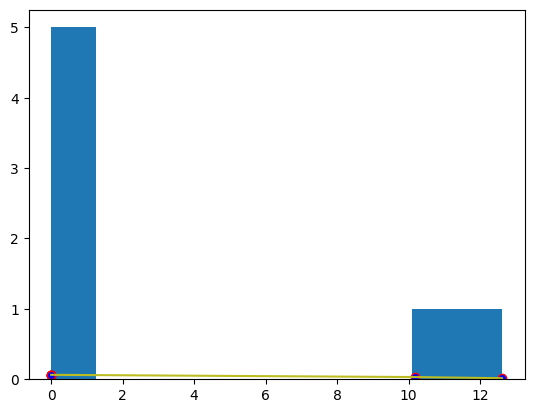

In [575]:
from scipy.stats import norm
# Plot between -10 and 10 with .001 steps.
x_axis = sorted((df_both_shift['Avg time (ms)']/100).tolist())
print(x_axis)

plt.hist(x_axis)
for i in range(len(x_axis)):
    plt.plot(x_axis[i],  norm.pdf(x_axis,np.mean(x_axis),np.std(x_axis))[i], marker="o", markersize=6, markeredgecolor="red", markerfacecolor="blue")
plt.plot(x_axis, norm.pdf(x_axis,np.mean(x_axis),np.std(x_axis)))
plt.show()